# UPDATED to FEB12_2024

**Questions**
- why do the different GCMs all have the same warming levels? 
- Why is the SLE 2015 always smaller than the steady-state levels, from Fig. 1, it looks different? 

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

### Ben's documentation of the data:
- first column is the CMIP5 model run (it says RCP4.5, because that is what I used to calculate the "present day" mass, but the forcing for the equilibrium experiments came from the RCP8.5 runs);
- second column is each CMIP5-model's ice mass in 2015, in mm SLE;
- the subsuquent columns are the ice masses (in mm SLE) at different temperature levels; the temperature level is in the first row (and calculated relative to 1986-2005, using HadCRUT4. 

I've investigated the data from the 2018 paper to see what I can offer you for the comparison with GlacierMIP3. This could be:

- the data in the figure, which are temperature relative to the mean of HadCRUT4 over 1851-1900 and the percentiles of the model ensemble (in mm SLE relative to my model's estimate for the present day based on CRU)
- the actual ensemble (i.e., the individual CMIP models' results) at each temperature level (which could also be relative to 1961-1990 CRU instead of 1851-1900);
- the expanded version (which includes temperature anomalies up to ~10 K, not shown in the paper)
- the model's estimate of present day ice mass based on CRU (so that you could calculate relative mass loss in percent, or the absolute mass) 

In [2]:
# numbers from compute_slr function from oggm-edu glacier explorer 
rho_oc = 1028
A_oc = 362.5 * 1e9
cte_gt_to_slr_mm = 1e12/(A_oc * rho_oc)  # Gt / mm SLR
cte_slr_mm_to_gt = 1/cte_gt_to_slr_mm # Gt / mm SLR
# approximately, maybe need to check with Ben 
#sigma_slr_glac_models = sigma_mass_loss_2020 * cte_gt_to_slr_mm 
#SLR = (mass_2020 - mass_yr)*cte
# mass_ch_diff_2015 = cte_slr_mm_to_gt * SLE

In [3]:
DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs' 

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
    pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)


except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    pd_global_temp_exp = pd.read_csv('temp_ch_ipcc_isimip3b.csv', index_col = 0)

from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous, compute_steady_state_yr
hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models
glac_models = hue_order

ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)
ds_reg_models = ds_reg_models.sel(model_author=glac_models)
ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp_g = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()


['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


In [4]:
ds_reg_models_extend_med_model_glob = ds_reg_models_extend.median(dim='model_author').sum(dim='rgi_reg')
med_initial_vol = ds_reg_models_extend_med_model_glob.volume_m3.sel(simulation_year=0).mean().values
# actually we need to drop RGI05 and RGI19 
ds_reg_models_extend_med_model_glob_no_05_19 = ds_reg_models_extend.drop_sel(rgi_reg=['05','19']).median(dim='model_author').sum(dim='rgi_reg')
med_initial_vol_no_05_19 = ds_reg_models_extend_med_model_glob_no_05_19.volume_m3.sel(simulation_year=0).mean().values


In [5]:
y_rel = 100*ds_reg_models_extend_med_model_glob.volume_m3.sel(simulation_year=slice(4900,5000),   # 4901
                                                              ).mean(dim='simulation_year')/med_initial_vol
y_rel = y_rel.to_dataframe()#.reset_index()
y_rel.loc[pd_global_temp_exp_g.index, 'temp_ch_ipcc'] = pd_global_temp_exp_g['temp_ch_ipcc']
y_rel = y_rel.reset_index()
y_rel = y_rel.drop(columns=['gcm', 'period_scenario', 'extend_option'])
y_rel['option'] = 'This study (GlacierMIP3 median)'
y_rel = y_rel.rename(columns={'volume_m3':'mass_ch_rel_init'})

###
y_rel_no_05_19 = 100*ds_reg_models_extend_med_model_glob_no_05_19.volume_m3.sel(simulation_year=slice(4900,5000),
                                                              ).mean(dim='simulation_year')/med_initial_vol_no_05_19
y_rel_no_05_19 = y_rel_no_05_19.to_dataframe()#.reset_index()
y_rel_no_05_19.loc[pd_global_temp_exp_g.index, 'temp_ch_ipcc'] = pd_global_temp_exp_g['temp_ch_ipcc']
y_rel_no_05_19 = y_rel_no_05_19.reset_index()
y_rel_no_05_19 = y_rel_no_05_19.drop(columns=['gcm', 'period_scenario', 'extend_option'])
y_rel_no_05_19['option'] = 'This study (GlacierMIP3 median)\nNo RGI19 & RGI05'
y_rel_no_05_19 = y_rel_no_05_19.rename(columns={'volume_m3':'mass_ch_rel_init'})
#
# oggm-vas  --- we have excluded oggm-vas from here ... 
include_oggm_vas = False
if include_oggm_vas: 
    ds_reg_models_extend_oggm_vas_model_glob_no_05_19 = ds_reg_models_extend.drop_sel(rgi_reg=['05','19']).sel(model_author='OGGM-VAS').sum(dim='rgi_reg')
    oggm_vas_initial_vol = ds_reg_models_extend_oggm_vas_model_glob_no_05_19.volume_m3.sel(simulation_year=0).mean().values
    y_rel_no_05_19_oggm_vas = 100*ds_reg_models_extend_oggm_vas_model_glob_no_05_19.volume_m3.sel(simulation_year=slice(4900,5000),
                                                                  ).mean(dim='simulation_year')/oggm_vas_initial_vol
    y_rel_no_05_19_oggm_vas = y_rel_no_05_19_oggm_vas.to_dataframe()#.reset_index()
    y_rel_no_05_19_oggm_vas.loc[pd_global_temp_exp_g.index, 'temp_ch_ipcc'] = pd_global_temp_exp_g['temp_ch_ipcc']
    y_rel_no_05_19_oggm_vas = y_rel_no_05_19_oggm_vas.reset_index()
    y_rel_no_05_19_oggm_vas = y_rel_no_05_19_oggm_vas.drop(columns=['gcm', 'period_scenario', 'extend_option', 'model_author'])
    y_rel_no_05_19_oggm_vas['option'] = 'GlacierMIP3 OGGM-VAS\nNo RGI19 & RGI05'
    y_rel_no_05_19_oggm_vas = y_rel_no_05_19_oggm_vas.rename(columns={'volume_m3':'mass_ch_rel_init'})

In [6]:
pd_m = pd.read_csv('data/data_from_others/marzeion_et_al_2018_data_for_glacierMIP3.txt', index_col=0)

pd_m_sle_2015_mm = pd_m['SLE_2015'].T

pd_m_sle_mm_temp_levels_rel_1986_2015 = pd_m.T.iloc[2:]
pd_m_sle_mm_temp_levels_rel_1986_2015.index = pd_m_sle_mm_temp_levels_rel_1986_2015.index.astype(float)
# assumed warming between preindustrial to 1986-2005
pd_m_sle_mm_temp_levels_rel_preindustrial_ipcc_index = pd_m_sle_mm_temp_levels_rel_1986_2015.index.astype(float) + 0.63 
pd_m_sle_mm_temp_levels_rel_preindustrial_ipcc = pd_m_sle_mm_temp_levels_rel_1986_2015.copy()
pd_m_sle_mm_temp_levels_rel_preindustrial_ipcc.index = pd_m_sle_mm_temp_levels_rel_preindustrial_ipcc_index

In [7]:
### QUICK check : maximum of 2015 SLE
# maximum of steady-state SLE -> it is always lower than SLE_2015!!! 
# -> Why are their terms with 0% change in glacier equilibrium mass change???
# pd_m_sle_mm_temp_levels_rel_1986_2015.max().max()
#pd_m['SLE_2015']
# the reason is that Ben used CRU for the comparison
# from Ben SLE CRU_from_2003 or 2004 (rounded it is the same)
SLE_CRU_from_2003 = 316 #mm SLE 
#mass_ch_rel_2015 = cte_slr_mm_to_gt * pd_m_sle_mm_rel_2015_temp_levels_rel_preindustrial_ipcc

In [8]:
pd_m_rel_2015_temp_levels_rel_preindustrial_ipcc = 100*pd_m_sle_mm_temp_levels_rel_preindustrial_ipcc/SLE_CRU_from_2003

In [9]:
pd_rel_2015_m = pd_m_rel_2015_temp_levels_rel_preindustrial_ipcc.melt(ignore_index=False).reset_index().dropna()
pd_rel_2015_m = pd_rel_2015_m.rename(columns={'index':'temp_ch_ipcc', 'value':'mass_ch_rel_init'})
pd_rel_2015_m['option'] = 'Marzeion et al. (2018)\nNo RGI19 & RGI05'
pd_rel_2015_m = pd_rel_2015_m.drop(columns='model')

In [10]:
common_min = max(pd_rel_2015_m['temp_ch_ipcc'].min(), pd_global_temp_exp_g['temp_ch_ipcc'].min())
common_max = min(pd_rel_2015_m['temp_ch_ipcc'].max(), pd_global_temp_exp_g['temp_ch_ipcc'].max())
print(common_min, common_max)

0.07830000000000004 6.824361023524889


In [11]:
if include_oggm_vas: 
    cols = [pd_rel_2015_m,y_rel_no_05_19,y_rel,y_rel_no_05_19_oggm_vas]
else:
    cols = [pd_rel_2015_m,y_rel_no_05_19,y_rel]
pd_rel_all = pd.concat(cols).copy()
# common_min is very near to zero... let's just use zero
for j in np.arange(0,common_max,1):
    condi = (pd_rel_all['temp_ch_ipcc'] < 0 + 1+j) & (pd_rel_all['temp_ch_ipcc'] >= 0+j)
    temp_cat_mean = 0 + 0.5 +j
    pd_rel_all.loc[condi, 'temp_category'] = temp_cat_mean
#
#pd_rel_all = pd_rel_all.dropna()

pd_rel_all = pd_rel_all.loc[pd_rel_all.option != 'GlacierMIP3 OGGM-VAS\nNo RGI19 & RGI05']


In [12]:
#pd_lowess_fit = pd.read_csv('lowess_fits/fitted_lowess_best_frac_shift_years_rel_2020_101yr_avg_period_fit_to_median_lowess_added_current12deg_w_ice_loss_steady_state.csv', index_col=[0])
#pd_lowess_fit = pd_lowess_fit.loc[pd_lowess_fit.region=='Globally']
#frac = pd_lowess_fit.frac.unique()
df_quantiles_f = {}
from moepy import lowess, eda
cols_l = []
j  = 0
for option in pd_rel_all.option.unique():
    pd_r = []
    for frac in [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]: 
        _pd_rel_all = pd_rel_all.loc[pd_rel_all.option==option]
        x = _pd_rel_all['temp_ch_ipcc'].values
        y = _pd_rel_all['mass_ch_rel_init'].values
        eval_x =np.arange(0, 7, 0.05)
        N = 100
        it = 2
        qs = [0.5]
        #frac = 0.32
        df_quantiles = lowess.quantile_model(x, y, x_pred=eval_x,
                                             frac=frac, num_fits=N, robust_iters=it,
                                             qs=qs)
        #df_quantiles['0.5_rel_Farinotti'] = df_quantiles[0.5] / pd_lowess_fit.loc[pd_lowess_fit.region == 'Globally', 'regional_volume_m3_itmix_vs_2020'].mean()
        q = 0.5
        lowi = df_quantiles[q].copy()
        lowi[lowi<0] = 0
        df_quantiles[f'min_{q}_diff_above_zero'] = (lowi.iloc[:len(eval_x)-1].values - lowi.iloc[1:len(eval_x)].values).min()
        df_quantiles['frac'] = frac
        df_quantiles = df_quantiles.reset_index()

        pd_r.append(df_quantiles)
    df_quantiles_ll_concat = pd.concat(pd_r)
    _max_min_diff =df_quantiles_ll_concat.groupby('frac')[f'min_{q}_diff_above_zero'].min()
    frac = _max_min_diff.idxmax().round(3)
    _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac.round(3) == frac]

    df_quantiles_f[f'{option}_{frac}'] = _sel
    cols_l.append(f'C{j}')
    j +=1


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


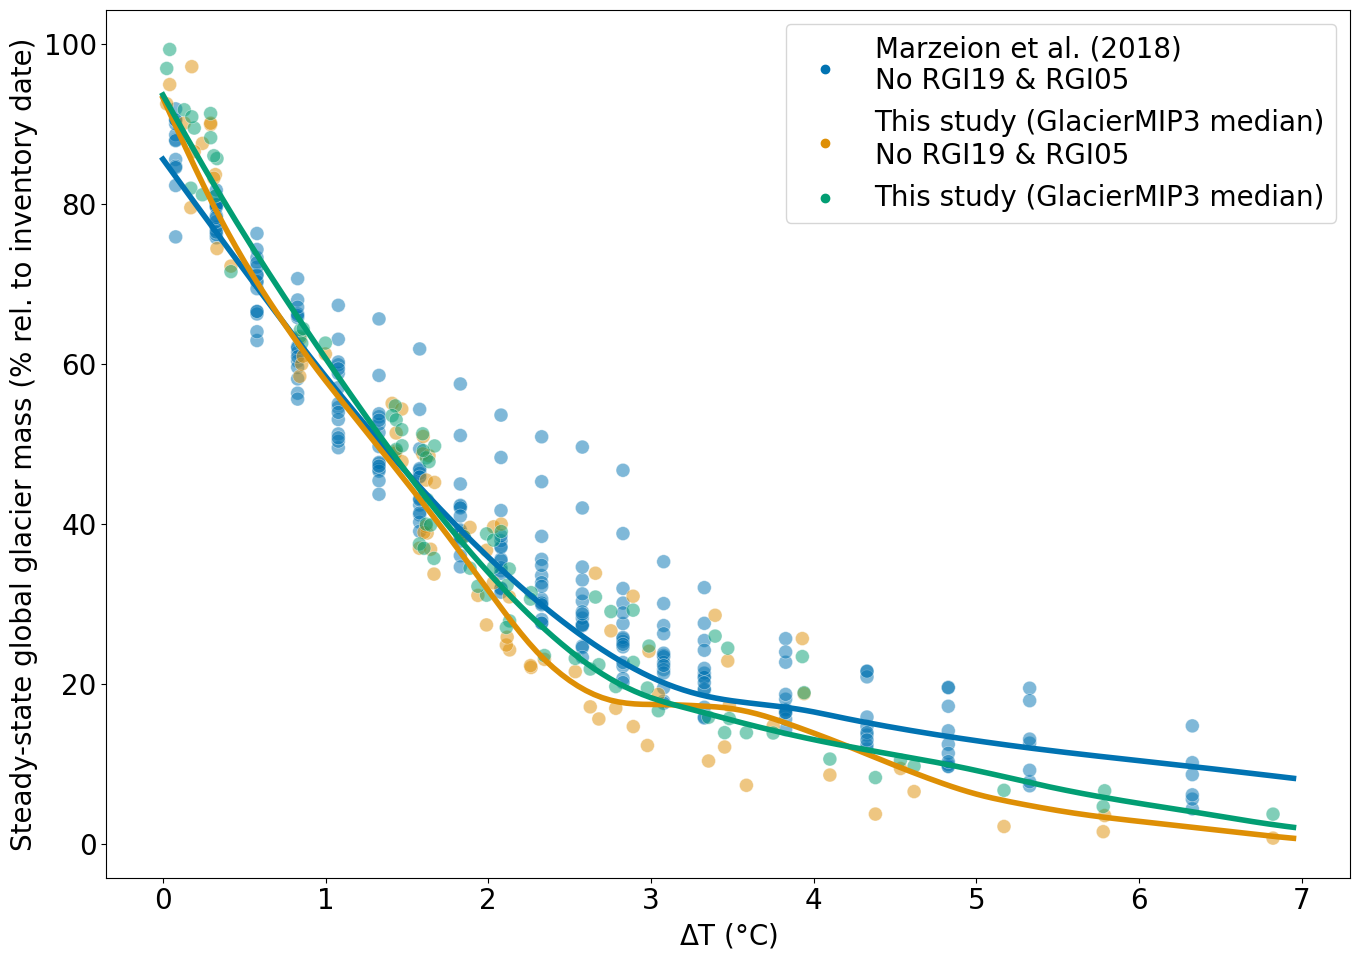

In [15]:
cols_l = sns.color_palette('colorblind')[:3]
# only experiments from 0 to 7 °C
pd_rel_all = pd_rel_all.loc[(pd_rel_all.temp_ch_ipcc>=0)& ((pd_rel_all.temp_ch_ipcc<=7))]

#pd_lowess_fit.index = pd_lowess_fit.x
#pd_lowess_fit['0.5_rel_Farinotti'] = pd_lowess_fit['0.5'] / pd_lowess_fit['regional_volume_m3_itmix_vs_2020']

plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 20})

sns.scatterplot(data=pd_rel_all, x='temp_ch_ipcc', y='mass_ch_rel_init', hue='option', alpha = 0.5, palette=sns.color_palette(cols_l)) #, hue='model')
#plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.xlabel(r'$\Delta$T (°C)')

plt.ylabel('Steady-state global glacier mass (% rel. to inventory date)')

plt.gca().collections[0].set_sizes([100])                 # <---- reset markersize here
###
plt.legend()
ylim0 = plt.gca().get_ylim()
#plt.axvline(common_min, color='grey')
#plt.axvline(common_max, color='grey')
#sns.lineplot(data=pd_lowess_fit, x='x', y='0.5_rel_Farinotti', color='red', lw=1)

for j,option in enumerate(df_quantiles_f.keys()): 
    _sel = df_quantiles_f[option]
    _sel = _sel.loc[(_sel.x>=0)&(_sel.x<=7)]
    sns.lineplot(data= _sel, x='x', y=0.5, lw=4,
                 alpha = 1, 
                color=cols_l[j])



plt.tight_layout()
plt.savefig(f'figures/5_comparison_mar2018_gmip3_no_oggm-vas_fit{DATE}.png', dpi=200)

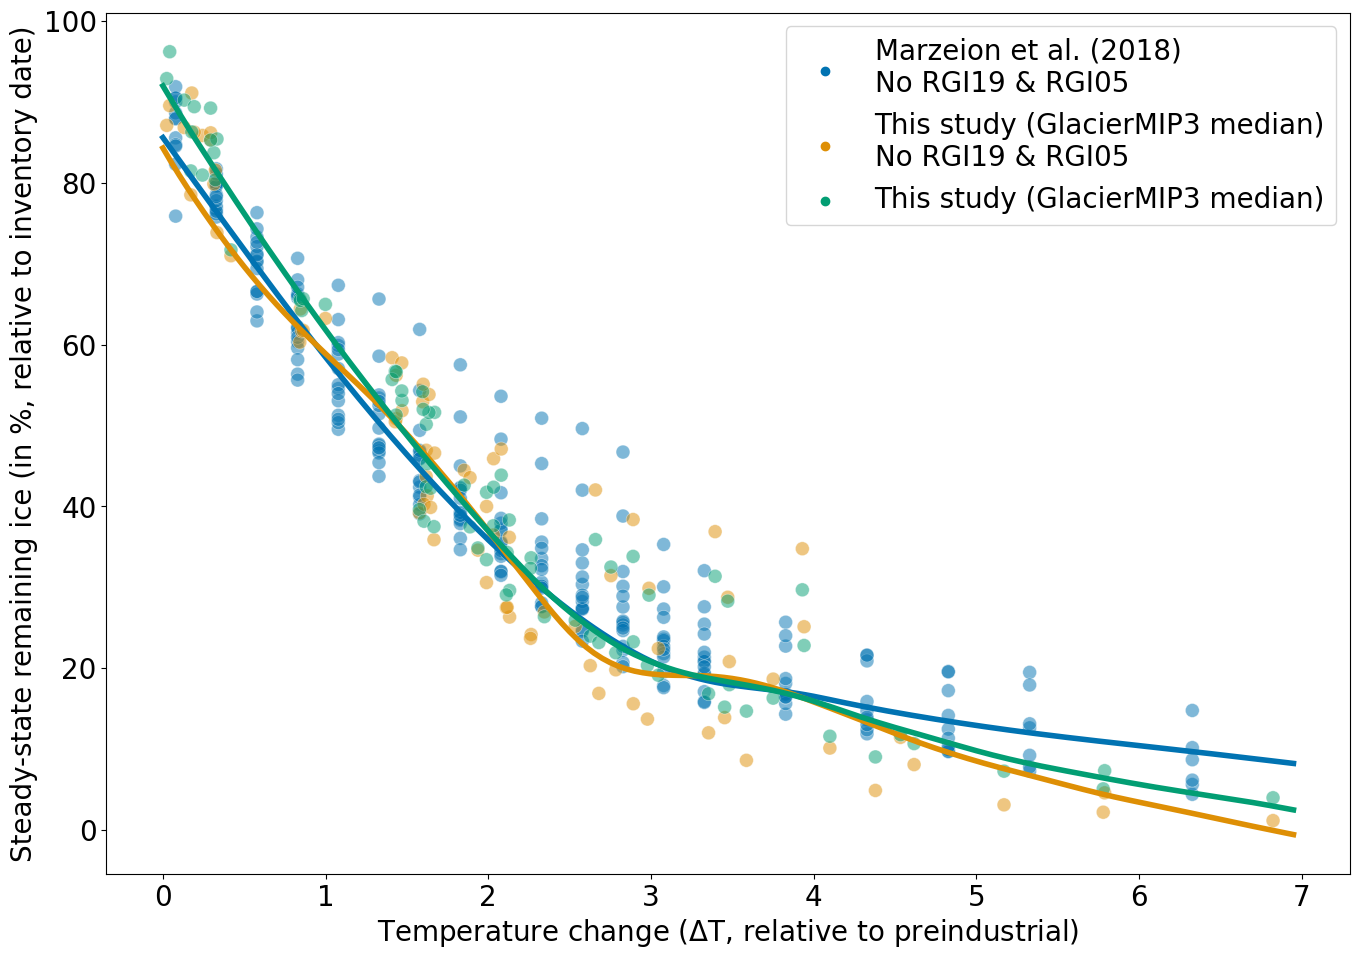

In [238]:
cols_l = sns.color_palette('colorblind')[:3]
# only experiments from 0 to 7 °C
pd_rel_all = pd_rel_all.loc[(pd_rel_all.temp_ch_ipcc>=0)& ((pd_rel_all.temp_ch_ipcc<=7))]

#pd_lowess_fit.index = pd_lowess_fit.x
#pd_lowess_fit['0.5_rel_Farinotti'] = pd_lowess_fit['0.5'] / pd_lowess_fit['regional_volume_m3_itmix_vs_2020']

plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 20})

sns.scatterplot(data=pd_rel_all, x='temp_ch_ipcc', y='mass_ch_rel_init', hue='option', alpha = 0.5, palette=sns.color_palette(cols_l)) #, hue='model')
plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state remaining ice (in %, relative to inventory date)')

plt.gca().collections[0].set_sizes([100])                 # <---- reset markersize here
###
plt.legend()
ylim0 = plt.gca().get_ylim()
#plt.axvline(common_min, color='grey')
#plt.axvline(common_max, color='grey')
#sns.lineplot(data=pd_lowess_fit, x='x', y='0.5_rel_Farinotti', color='red', lw=1)

for j,option in enumerate(df_quantiles_f.keys()): 
    _sel = df_quantiles_f[option]
    _sel = _sel.loc[(_sel.x>=0)&(_sel.x<=7)]
    sns.lineplot(data= _sel, x='x', y=0.5, lw=4,
                 alpha = 1, 
                color=cols_l[j])



plt.tight_layout()
plt.savefig(f'5_comparison_mar2018_gmip3_no_oggm-vas_fit{DATE}.png', dpi=200)

- Mar2018:
    - steady-state sea level equivalent of CRU from 2003 (316 mm SLE, number from Ben) used to estimate the factor we divide the steady-state SLE estimates from Marzeion et al. (2018)
        - we show in yaxis: `SLE_steady_state/SLE_2003`
    - temperature change relative to preindustrial: calculated relative to 1986-2005 using HadCRUT4 and +0.63 added (to be similar to IPCC)
        - Attention: $\Delta$T is the same for the different GCMs (Why Ben?)
- GlacierMIP3:
    - compute steady-state volume (last 20 years of simulation)  relativ to initial state (i.e. the RGI state around 2003)
        - we show in yaxis: `vol_steady_state/vol_init_state`
    - temperature change relative to preindustrial: calculated for every GCM separately relative to 1986-2005 and +0.63 added (to be similar to IPCC)
    
- boxplots on the right show 5,25,50,75,95 percentile, inaddition the raw points
    - attention: different amount of data points per temperature category
    - here gridded to 0-1°C, 1-2°C, 2-3°C, ...
   



### Old plot

In [ ]:
pd_rel_all = pd.concat([pd_rel_2015_m,y_rel,y_rel_no_05_19,y_rel_no_05_19_oggm_vas]).copy()
# common_min is very near to zero... let's just use zero
for j in np.arange(0,common_max,1):
    condi = (pd_rel_all['temp_ch_ipcc'] < 0 + 1+j) & (pd_rel_all['temp_ch_ipcc'] >= 0+j)
    temp_cat_mean = 0 + 0.5 +j
    pd_rel_all.loc[condi, 'temp_category'] = temp_cat_mean
pd_rel_all = pd_rel_all.dropna()

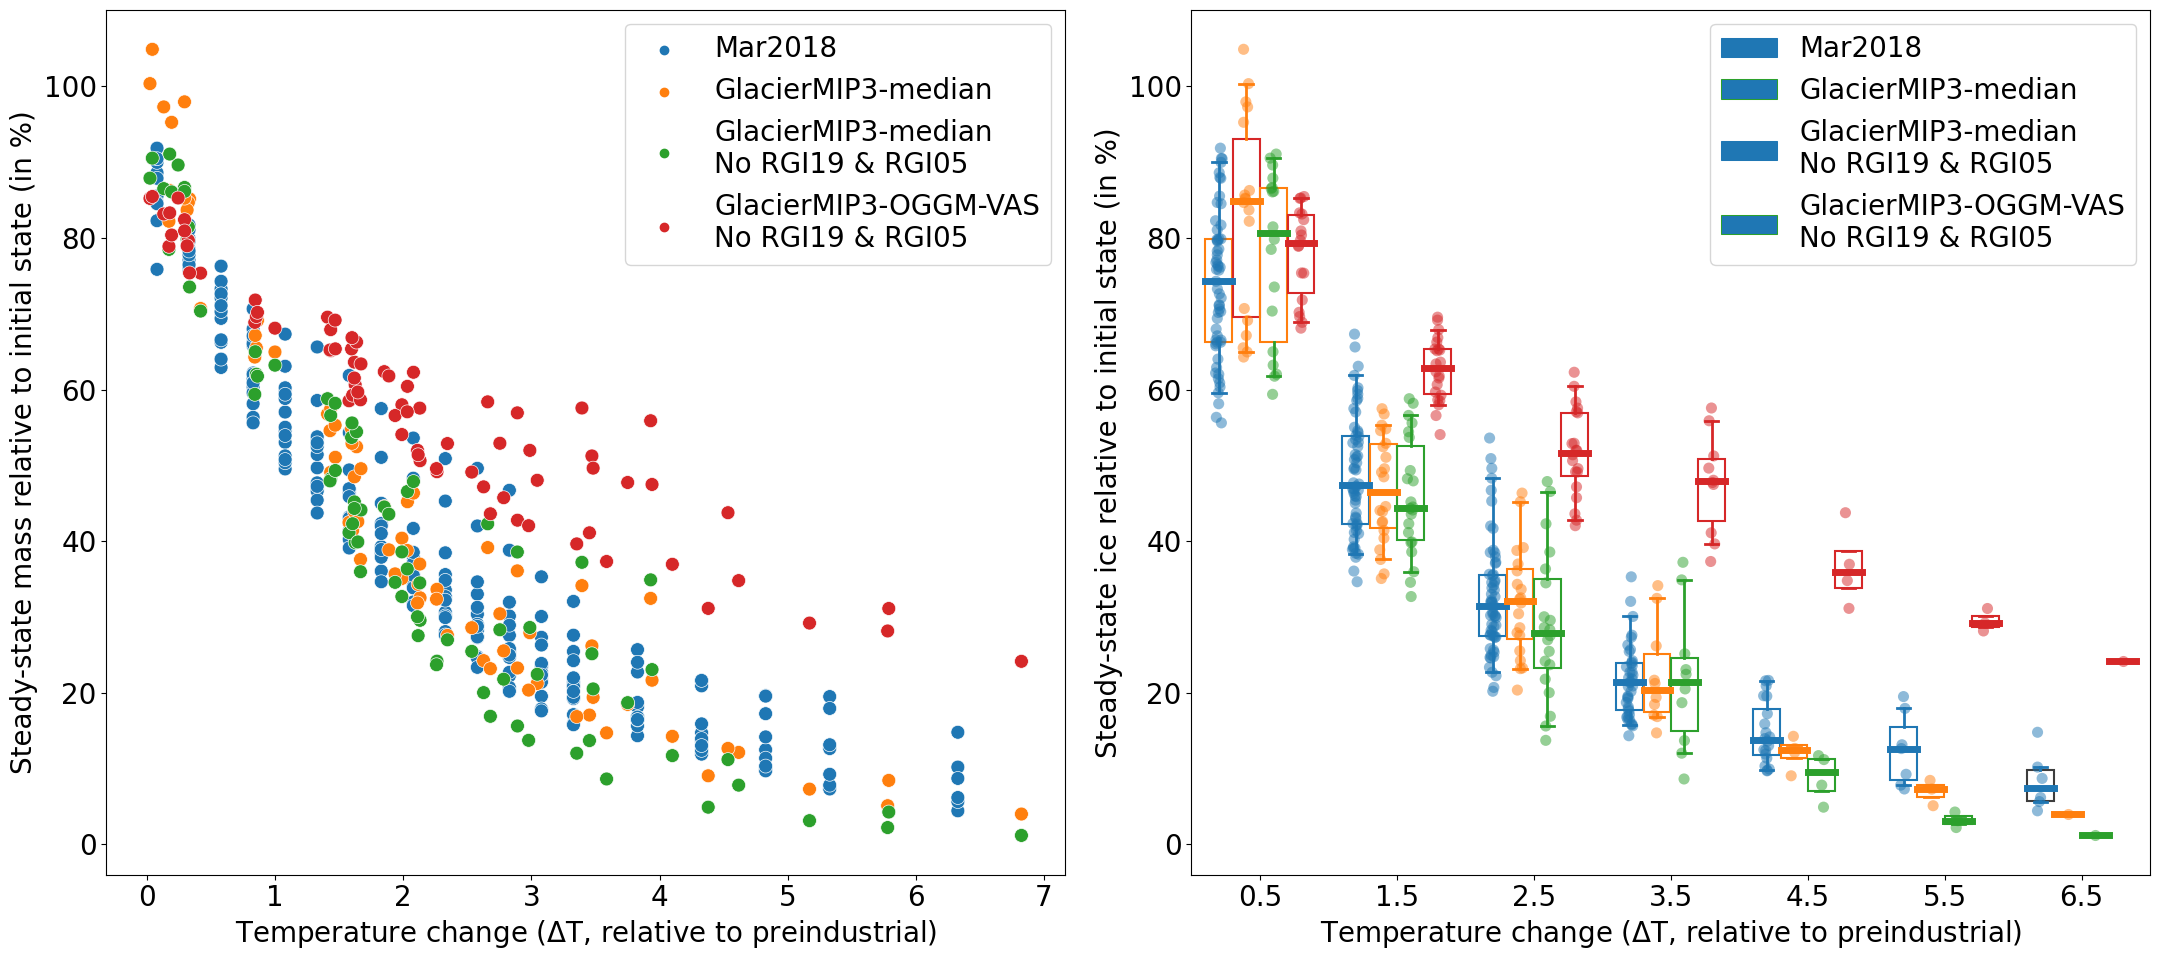

In [14]:
plt.figure(figsize=(22,10))
plt.rcParams.update({'font.size': 20})

plt.subplot(121)
sns.scatterplot(data=pd_rel_all, x='temp_ch_ipcc', y='mass_ch_rel_init', hue='option') #, hue='model')
plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state mass relative to initial state (in %)')
plt.gca().collections[0].set_sizes([100])                 # <---- reset markersize here
###
plt.legend()
ylim0 = plt.gca().get_ylim()
#plt.axvline(common_min, color='grey')
#plt.axvline(common_max, color='grey')

plt.subplot(122)
g = sns.boxplot(data=pd_rel_all, x='temp_category', y='mass_ch_rel_init',
            boxprops={'fill': None}, whis=[5,95],fliersize=0,
            hue='option') #, hue='model')
box_line_col = ['C0','C1','C2','C3']*7 # As many boxplots as you have

for i,box_col in enumerate(box_line_col):
    try:
        mybox = g.artists[i] # Or g.patches, in newer versions
    except:
        mybox = g.patches[i] # Or g.patches, in newer versions
    # Might want to skip any Rectangles (from legend)
    mybox.set_edgecolor(box_col)
    mybox.set_facecolor(None) #or white, if that's what you want

    # If you want the whiskers etc to match, each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for k,j in enumerate(range(i*6,i*6+6)):
        line = g.lines[j]
        if k == 4:
            line.set_linewidth(5)
        else:
            line.set_linewidth(2)
        line.set_color(box_col)
        line.set_mfc(box_col)
        line.set_mec(box_col)
plt.legend()

sns.stripplot(data=pd_rel_all, x='temp_category', y='mass_ch_rel_init',
              alpha = 0.5, size=8,
              dodge=True, hue='option', legend=False) #, hue='option')
plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state ice relative to initial state (in %)')

plt.gca().set_ylim(ylim0)
plt.tight_layout()
plt.savefig('5_comparison_mar2018_gmip3.png')

<AxesSubplot:xlabel='x', ylabel='0.5_rel_Farinotti'>

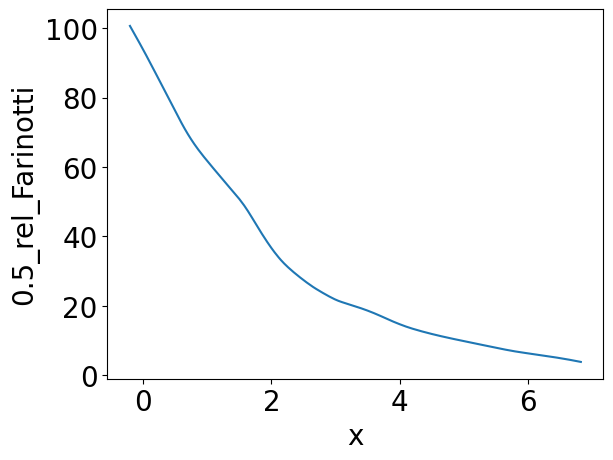

IndexError: list index out of range

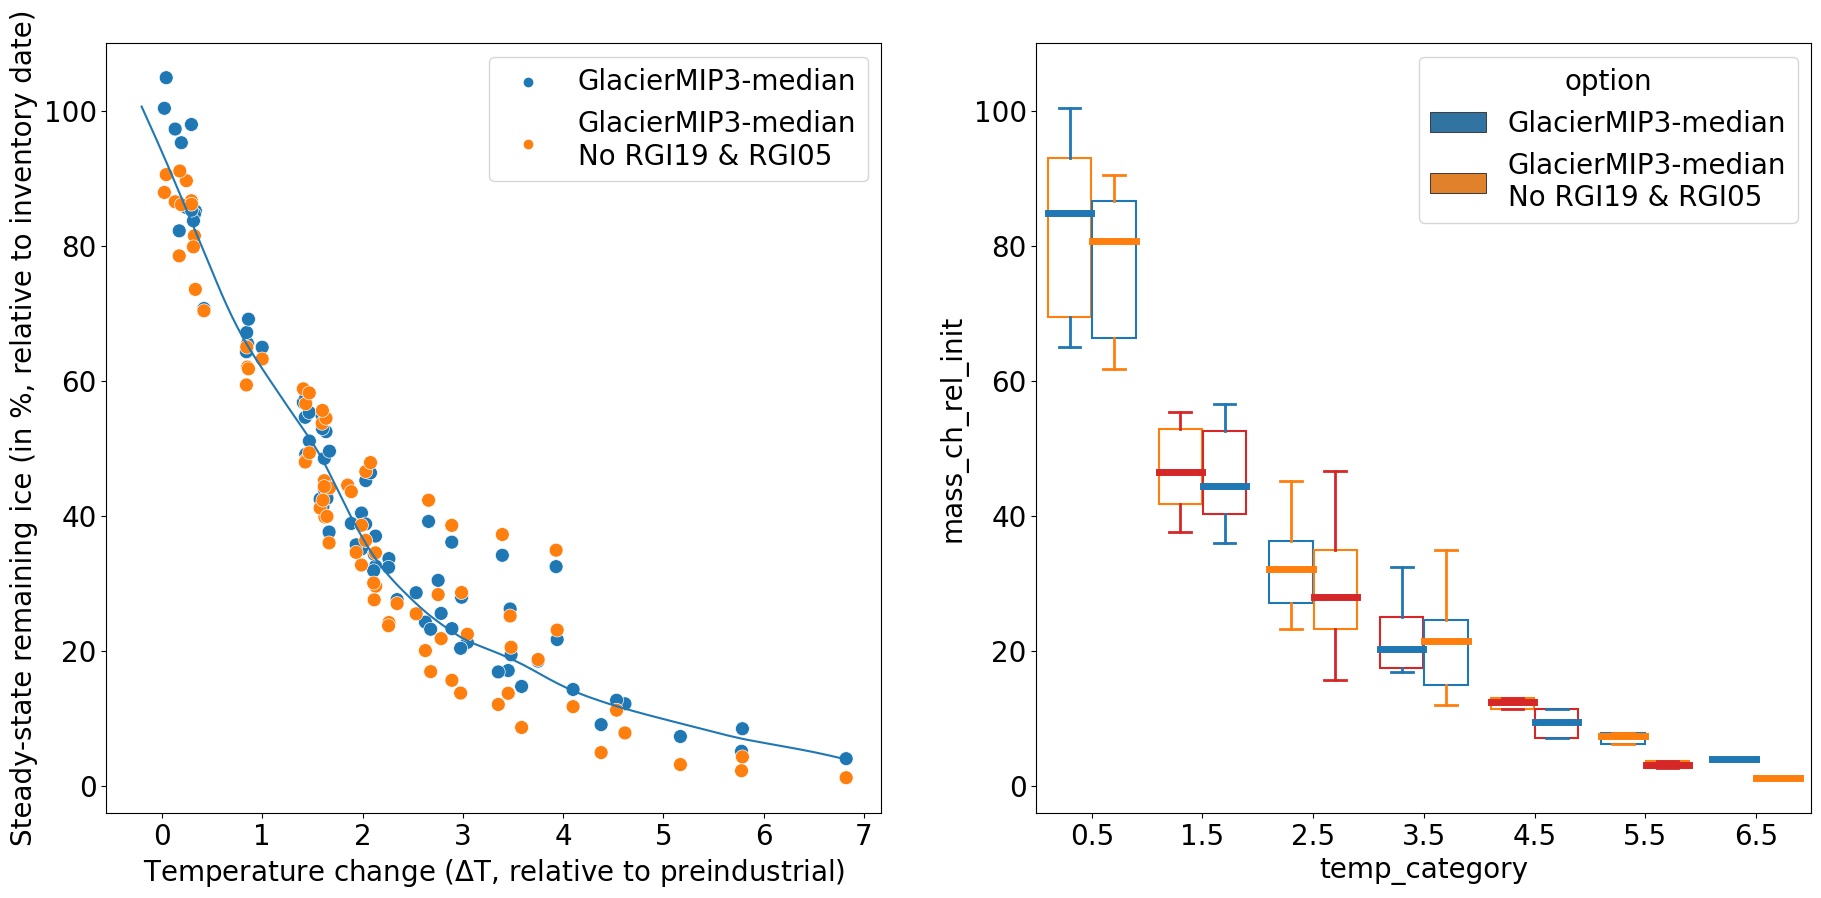

<AxesSubplot:xlabel='temp_ch_ipcc', ylabel='mass_ch_rel_init'>

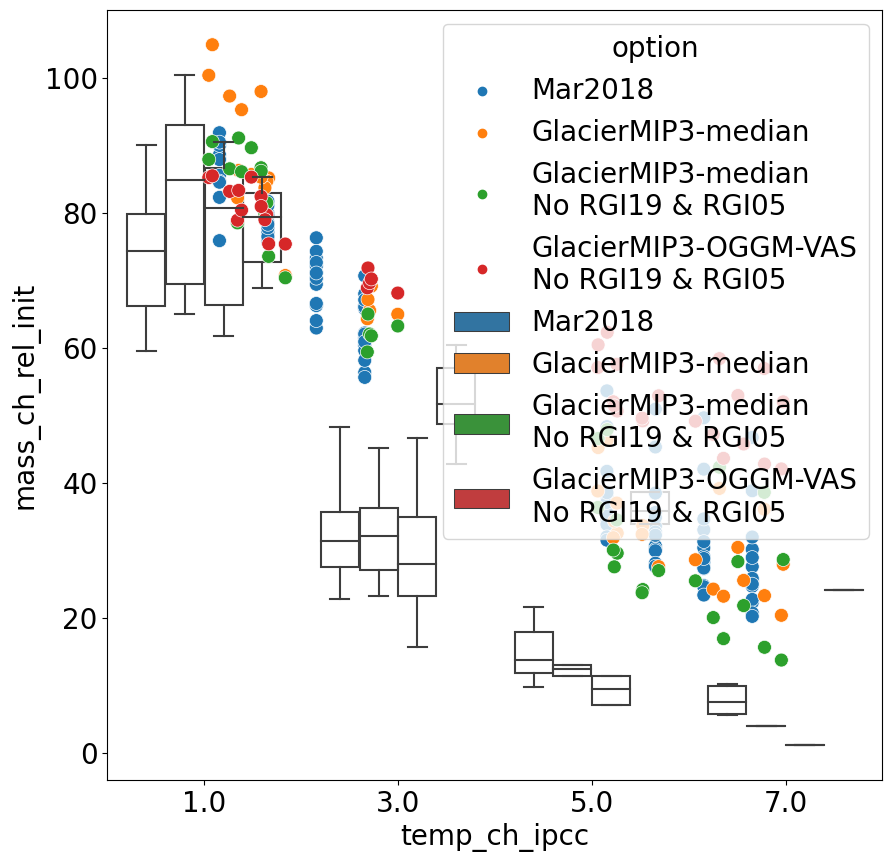

In [41]:
pd_rel_all = pd.concat([pd_rel_2015_m,y_rel,y_rel_no_05_19,y_rel_no_05_19_oggm_vas]).copy()
# common_min is very near to zero... let's just use zero
for j in np.arange(0,common_max,2):
    condi = (pd_rel_all['temp_ch_ipcc'] < 0 + 1+j) & (pd_rel_all['temp_ch_ipcc'] >= 0+j)
    temp_cat_mean = 0 + 1 +j
    pd_rel_all.loc[condi, 'temp_category'] = temp_cat_mean
pd_rel_all = pd_rel_all.dropna()

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 20})

sns.scatterplot(data=pd_rel_all, x='temp_ch_ipcc', y='mass_ch_rel_init', hue='option') #, hue='model')
plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state mass relative to initial state (in %)')
plt.gca().collections[0].set_sizes([100])                 # <---- reset markersize here
###
pd_rel_all_cat = pd_rel_all.copy()
pd_rel_all_cat['temp_ch_ipcc'] = pd_rel_all_cat['temp_category'].values
plt.legend()
sns.boxplot(data=pd_rel_all_cat, x='temp_ch_ipcc', y='mass_ch_rel_init',
            boxprops={'fill': None}, whis=[5,95],fliersize=0,
            hue='option')


#ylim0 = plt.gca().get_ylim()
#plt.axvline(common_min, color='grey')

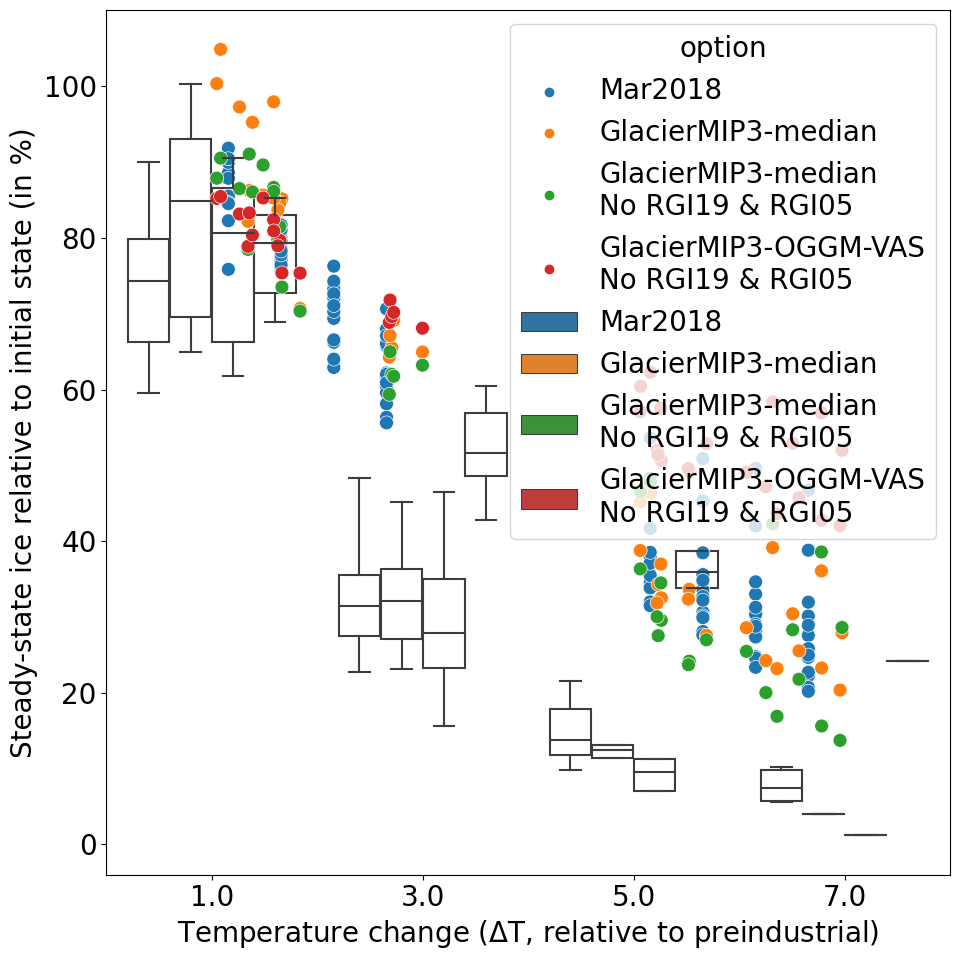

In [34]:
pd_rel_all = pd.concat([pd_rel_2015_m,y_rel,y_rel_no_05_19,y_rel_no_05_19_oggm_vas]).copy()
# common_min is very near to zero... let's just use zero
for j in np.arange(0,common_max,2):
    condi = (pd_rel_all['temp_ch_ipcc'] < 0 + 1+j) & (pd_rel_all['temp_ch_ipcc'] >= 0+j)
    temp_cat_mean = 0 + 1 +j
    pd_rel_all.loc[condi, 'temp_category'] = temp_cat_mean
pd_rel_all = pd_rel_all.dropna()

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 20})

sns.scatterplot(data=pd_rel_all, x='temp_ch_ipcc', y='mass_ch_rel_init', hue='option') #, hue='model')
plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state mass relative to initial state (in %)')
plt.gca().collections[0].set_sizes([100])                 # <---- reset markersize here
###
plt.legend()
#ylim0 = plt.gca().get_ylim()
#plt.axvline(common_min, color='grey')
#plt.axvline(common_max, color='grey')

g = sns.boxplot(data=pd_rel_all, x='temp_category', y='mass_ch_rel_init',
            boxprops={'fill': None}, whis=[5,95],fliersize=0,
            hue='option') #, hue='model')
#box_line_col = ['C0','C1','C2','C3']*7 # As many boxplots as you have

plt.xlabel(r'Temperature change ($\Delta$T, relative to preindustrial)')
plt.ylabel('Steady-state ice relative to initial state (in %)')

#lt.gca().set_ylim(ylim0)
plt.tight_layout()
plt.savefig('5_comparison_mar2018_gmip3_new.png')

In [348]:
sns.stripplot

<function seaborn.categorical.stripplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, jitter=True, dodge=False, orient=None, color=None, palette=None, size=5, edgecolor='gray', linewidth=0, hue_norm=None, native_scale=False, formatter=None, legend='auto', ax=None, **kwargs)>

In [278]:
(pd_m_sle_mm_rel_2015_temp_levels_rel_preindustrial_ipcc).max()

model
bcc-csm1-1_rcp45_r1i1p1       79.429260
CanESM2_rcp45_r1i1p1          72.230735
CCSM4_rcp45_r1i1p1            76.868709
CNRM-CM5_rcp45_r1i1p1         80.611851
CSIRO-Mk3-6-0_rcp45_r1i1p1    80.116085
GFDL-CM3_rcp45_r1i1p1         74.385037
GISS-E2-R_rcp45_r1i1p1        79.942894
HadGEM2-ES_rcp45_r1i1p1       71.794786
inmcm4_rcp45_r1i1p1           75.584505
IPSL-CM5A-LR_rcp45_r1i1p1     77.874684
MIROC5_rcp45_r1i1p1           74.860457
MIROC-ESM_rcp45_r1i1p1        80.253057
MPI-ESM-LR_rcp45_r1i1p1       81.454737
MRI-CGCM3_rcp45_r1i1p1        82.205199
NorESM1-M_rcp45_r1i1p1        82.648100
dtype: float64